# Introduction to Boosting
References: 
- https://github.com/dmlc/xgboost/tree/master/demo/guide-python
- https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- http://xgboost.readthedocs.org/en/latest/parameter.html#general-parameters
- https://github.com/dmlc/xgboost/tree/master/demo/guide-python
- https://xgboost.readthedocs.io/en/latest/python/python_api.html

The term `Boosting` refers to a family of algorithms which converts weak learner to strong learners.

There are many boosting algorithms which impart additional boost to model’s accuracy. In this tutorial, we’ll learn about the two most commonly used algorithms i.e. Gradient Boosting (GBM) and XGboost.

Generally XGboost is considered more advanced than gbm. 
- xgboost supports regularization, however gbm does not.
- xgboost is blazingley faster than gbm.
- xgboost has built-in routine to handle missing values.
- xgboost has tree pruning mechanisms,however gbm and random forest are greedy algorithms and do not have tree pruning.
- In xgboost we can run cross-validation at each iteration of the boosting. But in gbm, we have to run grid search.

# Imports

In [0]:
import numpy as np
import pandas as pd

random_state = 100

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams.update({'font.size': 16})

plt.style.use('ggplot')
%matplotlib inline

In [0]:
import xgboost as xgb

In [0]:
# six and pickle
import six
import pickle
import joblib

In [0]:
# scale and split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [0]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
# sklearn scalar metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [0]:
# roc auc and curves
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [0]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Useful Scripts

In [0]:
def show_method_attributes(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

# Load the data

In [12]:
ifile = 'https://github.com/bhishanpdl/Project_Fraud_Detection/blob/master/data/raw/creditcard.csv.zip?raw=true'
df = pd.read_csv(ifile,compression='zip')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
target = 'Class'
df[target].value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

# Train test split with stratify

In [15]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    df.drop(target,axis=1), df[target],
    test_size=0.2, random_state=random_state, stratify=df[target])

df.shape, Xtrain.shape, Xtest.shape

((284807, 31), (227845, 30), (56962, 30))

In [16]:
df.columns.drop('Class')

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [17]:
df_Xtrain = pd.DataFrame(Xtrain, columns=df.columns.drop(target))
df_Xtest = pd.DataFrame(Xtest, columns=df.columns.drop(target))

print(df_Xtrain.shape)
df_Xtrain.head()

(227845, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
38082,39241.0,0.876451,-0.269217,-0.427168,1.028171,0.322079,0.276521,0.400895,0.029249,-0.372928,0.130866,0.729454,0.506439,-0.307878,0.755556,0.409504,0.145074,-0.620411,0.081633,-0.148672,0.198628,0.099495,-0.096336,-0.331152,-0.814000,0.651155,-0.296370,-0.022619,0.025406,184.00
167065,118467.0,2.247030,-1.535440,-1.141551,-1.539860,-0.750196,0.508158,-1.182796,0.066245,-1.020709,1.482775,-0.257914,0.395488,0.763674,-0.827855,-2.729673,-1.102738,0.707705,-0.269037,1.039588,-0.370285,-0.503624,-0.751449,0.246075,0.023190,-0.091952,-0.333751,0.018983,-0.060035,26.25
279720,169053.0,2.312026,-1.430082,-1.208911,-1.619857,-1.075136,-0.531039,-1.106151,-0.138716,-1.059177,1.603262,-1.482432,-1.514907,-0.643149,-0.196704,-0.033587,-0.461923,0.454282,0.118643,-0.000647,-0.458251,-0.201595,-0.163631,0.232024,0.425256,-0.149499,-0.175278,-0.005617,-0.048046,25.00
151962,96573.0,-0.689824,1.244675,-1.201144,-1.345560,2.073268,-0.499087,1.737302,-0.614551,1.130758,0.233345,1.273472,-1.775464,2.501764,1.678747,-1.530917,-0.377414,-0.461801,0.507434,0.252973,0.231514,-0.038991,0.714372,-0.238292,-0.132176,-0.087400,0.022356,0.303417,0.197012,28.00
204408,135264.0,1.907419,0.532621,-1.105841,3.575077,0.816681,0.098052,0.344680,-0.143617,-1.163691,1.517338,-1.355606,-0.391472,0.359299,0.344060,-0.271984,1.017174,-1.069623,-0.108660,-1.628020,-0.157134,0.228334,0.556437,0.022903,0.469545,0.179843,0.110297,-0.057236,-0.040840,43.13


# Modelling xgboost
```
Parameters:
-------------
max_depth=3
learning_rate=0.1
n_estimators=100
verbosity=1 **NOTE: it print in ipython terminal not in browser
silent=None **deprecated use verbosity
objective='binary:logistic' **for binary classification
booster='gbtree' **use default tree not linear
n_jobs=1 **make this -1
nthread=None **deprecated use n_jobs
gamma=0
min_child_weight=1
max_delta_step=0
subsample=1
colsample_bytree=1
colsample_bylevel=1
colsample_bynode=1
reg_alpha=0
reg_lambda=1
scale_pos_weight=1
base_score=0.5
random_state=0 **use your own random state
seed=None      **deprecated use random_state
missing=None
```

In [0]:
# help(XGBClassifier)

Model: Xgboost (Test scores):

Accuracy: 0.9994733330992591
Precision: 0.9994733330992591
Recall: 0.9994733330992591
F1-Score: 0.9994733330992591
[[56855     9]
 [   21    77]]
CPU times: user 1min 55s, sys: 43 ms, total: 1min 55s
Wall time: 1min 55s


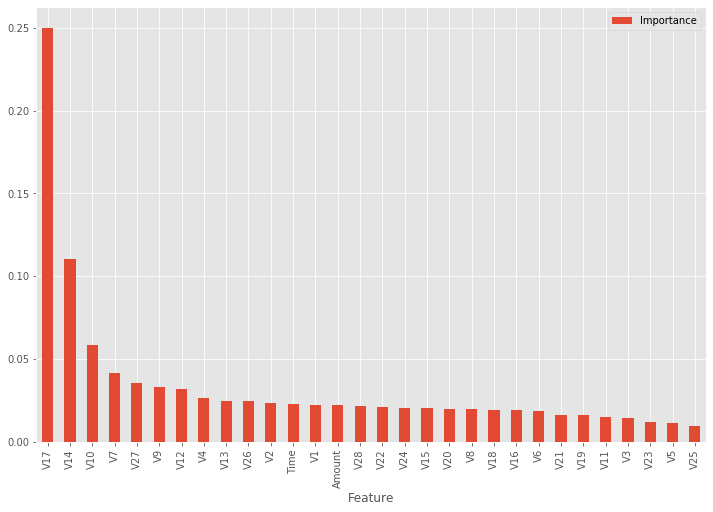

In [38]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score,  precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix

# model fit
clf_xgb = XGBClassifier(n_jobs=-1, random_state=random_state,
                        objective='binary:logistic')

clf_xgb.fit(Xtrain, ytrain)

# cross validation score
skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=random_state)
scores = cross_val_score(clf_xgb, Xtrain, ytrain, cv=skf, scoring = "accuracy")
train_acc = scores.mean()
print('Train Accuracy CV: ', train_acc)

# predictions
ypreds_cv = cross_val_predict(clf_xgb, Xtest, ytest, cv=skf)
ypreds = ypreds_cv

# model evaluation
print('Model: Xgboost (Test scores):\n')
print("Accuracy:", accuracy_score(ytest, ypreds))
print("Precision:", precision_score(ytest, ypreds, average='micro'))
print("Recall:",recall_score(ytest, ypreds, average='micro'))
print("F1-Score:", f1_score(ytest, ypreds, average='micro'))

# confusion matrix
print(confusion_matrix(ytest, ypreds))

# feature importance
df_imp = pd.DataFrame({
    'Feature': df.columns.drop(target).to_numpy(),
    'Importance': clf_xgb.feature_importances_
})


df_imp = df_imp.sort_values(by='Importance',ascending=False)
df_imp.set_index('Feature').plot.bar(figsize=(12,8))

## Random Forest

Model: Random Forest  (Test Scores):

Accuracy: 0.9994382219725431
Precision: 0.9994382219725431
Recall: 0.9994382219725431
F1-Score: 0.9994382219725431
[[56857     7]
 [   25    73]]
CPU times: user 4min 39s, sys: 464 ms, total: 4min 40s
Wall time: 4min 28s


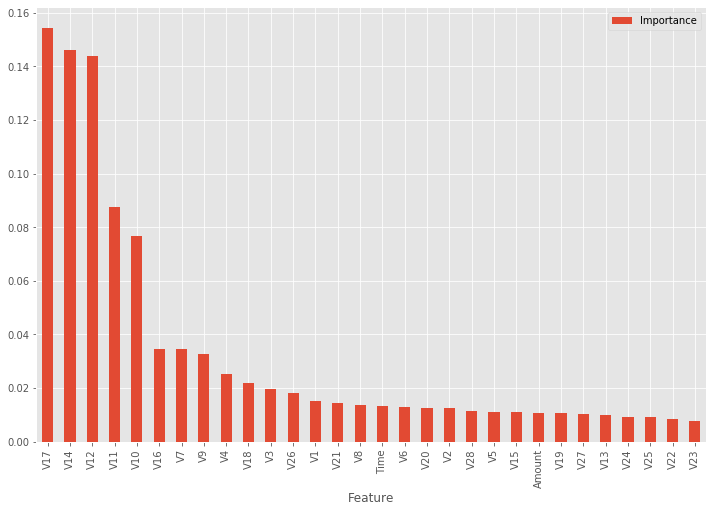

In [39]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix

# model fit
clf_rfc = RandomForestClassifier(n_estimators=100,
                                random_state=random_state,n_jobs=-1)


clf_rfc.fit(Xtrain, ytrain)

# cross validation score
skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=random_state)
scores = cross_val_score(clf_rfc, Xtrain, ytrain, cv=skf, scoring = "accuracy")
train_acc = scores.mean()
print('Train Accuracy CV: ', train_acc)

# predictions
ypreds_cv = cross_val_predict(clf_rfc, Xtest, ytest, cv=skf)
ypreds = ypreds_cv

# model evaluation
print('Model: Random Forest  (Test Scores):\n')
print("Accuracy:", accuracy_score(ytest, ypreds))
print("Precision:", precision_score(ytest, ypreds, average='micro'))
print("Recall:",recall_score(ytest, ypreds, average='micro'))
print("F1-Score:", f1_score(ytest, ypreds, average='micro'))

# confusion matrix
print(confusion_matrix(ytest, ypreds))

# feature importance
df_imp = pd.DataFrame({'Feature': df.columns.drop(target).to_numpy(),
                       'Importance': clf_rfc.feature_importances_})

df_imp = df_imp.sort_values(by='Importance',ascending=False)
df_imp.set_index('Feature').plot.bar(figsize=(12,8))

## Naive Bayes Classifier
Naive Bayes assumes normality of dataset. We can use MaxAbsScaler to gnb.

In [40]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.naive_bayes import GaussianNB

clf_gnb = Pipeline([
    ("scale", MaxAbsScaler()),
    ("model", GaussianNB())
])

clf_gnb.fit(Xtrain, ytrain)

# cross validation score
skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=random_state)
scores = cross_val_score(clf_gnb, Xtrain, ytrain, cv=skf, scoring = "accuracy")
train_acc = scores.mean()
print('Train Accuracy CV: ', train_acc)

# predictions
ypreds_cv = cross_val_predict(clf_gnb, Xtest, ytest, cv=skf)
ypreds = ypreds_cv

# model evaluation
print('Model: Naive Bayes (Test scores)\n')
print("Accuracy:", accuracy_score(ytest, ypreds))
print("Precision:", precision_score(ytest, ypreds, average='micro'))
print("Recall:",recall_score(ytest, ypreds, average='micro'))
print("F1-Score:", f1_score(ytest, ypreds, average='micro'))

# confusion matrix
print(confusion_matrix(ytest, ypreds))

# # feature importance
# df_imp = pd.DataFrame({'Feature': df.columns.drop(target).to_numpy(),
#                        'Importance': clf_rfc.feature_importances_})

# df_imp = df_imp.sort_values(by='Importance',ascending=False)
# df_imp.set_index('Feature').plot.bar(figsize=(12,8))

Train Accuracy CV:  0.9789462151870874
Model: Naive Bayes (Test scores)

Accuracy: 0.9781082124925389
Precision: 0.9781082124925389
Recall: 0.9781082124925389
F1-Score: 0.9781082124925389
[[55633  1231]
 [   16    82]]
CPU times: user 734 ms, sys: 19 ms, total: 753 ms
Wall time: 761 ms


In [41]:
show_method_attributes(clf_gnb)

,0,1,2,3,4,5,6
0,classes_,fit_predict,inverse_transform,predict,predict_proba,set_params,transform
1,decision_function,fit_transform,memory,predict_log_proba,score,steps,verbose
2,fit,get_params,named_steps,,,,


In [42]:
show_method_attributes(clf_rfc)

,0,1,2,3,4,5,6
0,apply,classes_,feature_importances_,max_leaf_nodes,min_weight_fraction_leaf,n_outputs_,random_state
1,base_estimator,criterion,fit,min_impurity_decrease,n_classes_,oob_score,score
2,base_estimator_,decision_path,get_params,min_impurity_split,n_estimators,predict,set_params
3,bootstrap,estimator_params,max_depth,min_samples_leaf,n_features_,predict_log_proba,verbose
4,class_weight,estimators_,max_features,min_samples_split,n_jobs,predict_proba,warm_start


In [43]:
show_method_attributes(clf_xgb)

,0,1,2,3,4,5,6
0,apply,colsample_bytree,get_num_boosting_rounds,learning_rate,n_classes_,predict_proba,score
1,base_score,evals_result,get_params,load_model,n_estimators,random_state,seed
2,booster,feature_importances_,get_xgb_params,max_delta_step,n_jobs,reg_alpha,set_params
3,classes_,fit,importance_type,max_depth,nthread,reg_lambda,silent
4,coef_,gamma,intercept_,min_child_weight,objective,save_model,subsample
5,colsample_bylevel,get_booster,kwargs,missing,predict,scale_pos_weight,verbosity
6,colsample_bynode,,,,,,
